In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

In [3]:
# Get naive and actual occupancy percentage data
X_data = pd.read_csv('X_data.csv')
X_data = np.array(X_data.values.tolist())
X_data = X_data[:,3]
print('Naive occupancy')
print(X_data[0:10])

Y_data = pd.read_csv('Y_data.csv')
Y_data = np.array(Y_data.values.tolist())
Y_data = Y_data[:,1]
print('Actual occupancy')
print(Y_data[0:10])

Naive occupancy
[0.286 0.286 0.321 0.321 0.321 0.321 0.321 0.357 0.357 0.357]
Actual occupancy
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


In [4]:
# Group data to day snapshot
X_data = np.reshape(X_data, (84,720))
print('Naive occupancy')
print(X_data.shape)
print(X_data[0][:10])


Y_data = np.reshape(Y_data, (84,720))
print('Actual occupancy')
print(Y_data.shape)
print(Y_data[0][:10])

Naive occupancy
(84, 720)
[0.286 0.286 0.321 0.321 0.321 0.321 0.321 0.357 0.357 0.357]
Actual occupancy
(84, 720)
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


In [5]:
# Get block names label for each of X/Y data
block_names = pd.read_csv('block_names.csv')
block_names = np.array(block_names.iloc[:,1])
print(block_names.shape)

(84,)


In [6]:
random_list = random.sample(range(0, 84), 9)

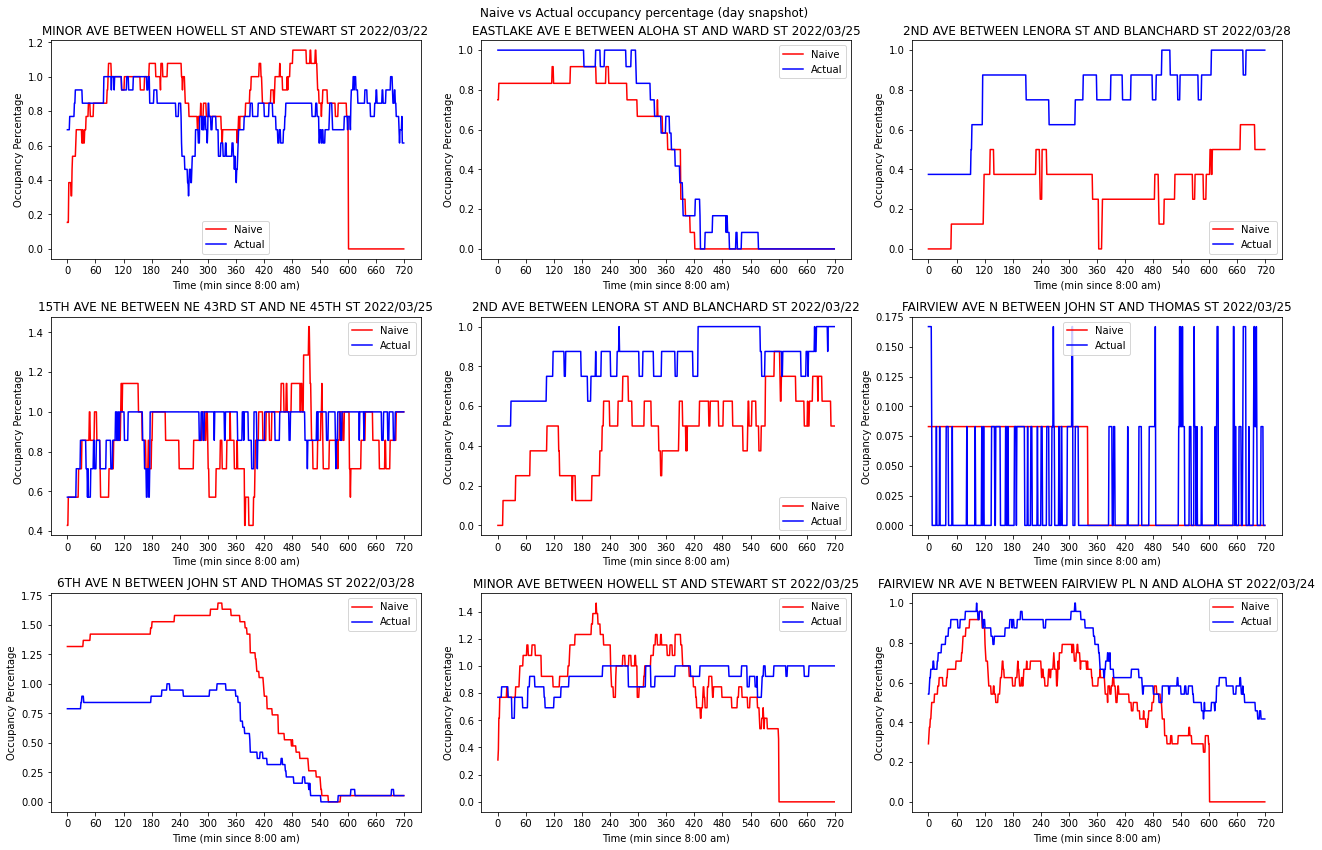

In [7]:
# Display random set of naive and actual occupancy percentage 

time = np.arange(720)

plt.figure(figsize=(18,12))
plt.suptitle('Naive vs Actual occupancy percentage (day snapshot)')

for i in range(9):
    index = random_list[i]
    plt.subplot(3, 3, i+1)
    plt.plot(time, X_data[index], color='r', label='Naive')
    plt.plot(time, Y_data[index], color='b', label='Actual')
    plt.legend()
    plt.xlabel('Time (min since 8:00 am)')
    plt.xticks(np.arange(0,780,60))
    plt.ylabel('Occupancy Percentage')
    plt.title(block_names[index])

plt.tight_layout()
plt.show()

In [35]:
period = 60
Y_coef = []
X_raw = []
index = np.arange(84)

for X, Y, i in zip(X_data, Y_data, index):
    coef = []
    raw = []
    coef.append(i)
    raw.append(i)
    for j in range(0,720,period):
        x = np.average(X[j:j+period])
        y = np.average(Y[j:j+period])
        coef.append(y-x)
        raw.append(x)
        
    Y_coef.append(coef)
    X_raw.append(raw)

Y_coef = np.array(Y_coef)
X_raw = np.array(X_raw)
print(Y_coef[0])
print(X_raw[0])


[ 0.          0.34165     0.13971667  0.06065    -0.00683333  0.13875
  0.23993333  0.06365     0.015       0.04705     0.03035     0.52971667
  0.41443333]
[0.         0.45425    0.6667     0.74226667 0.82141667 0.65775
 0.53156667 0.67495    0.67651667 0.61323333 0.50966667 0.00715
 0.        ]


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.20, random_state=2)

In [62]:
pcr = make_pipeline(PCA(n_components=12), LinearRegression())
pcr.fit(X_train, y_train)
X_predict = pcr.predict(X_test)

In [63]:
random_list = random.sample(range(0, len(y_test)), 9)

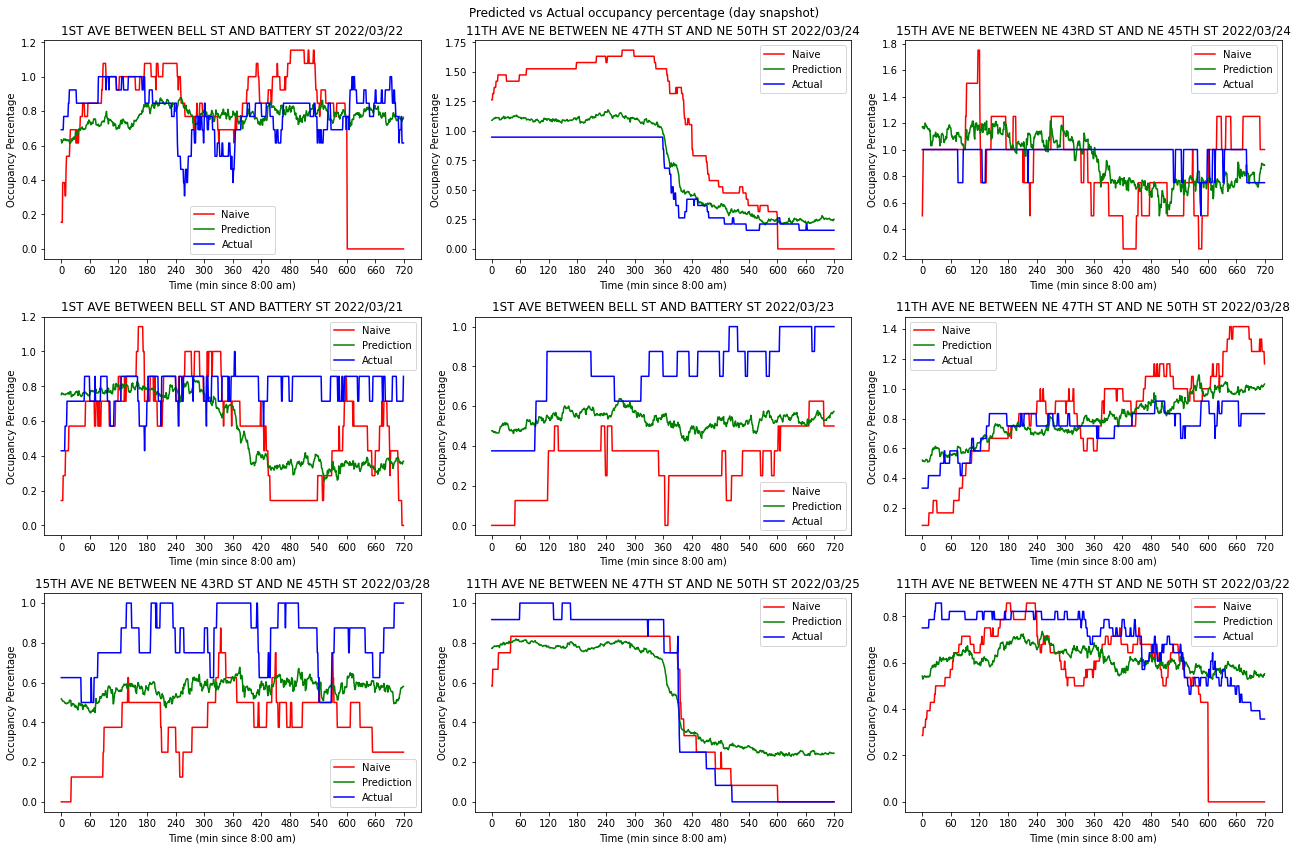

In [64]:
# Display random set of predicted and actual occupancy percentage 
plt.figure(figsize=(18,12))
plt.suptitle('Predicted vs Actual occupancy percentage (day snapshot)')

for i in range(9):
    index = random_list[i]
    plt.subplot(3, 3, i+1)
    plt.plot(time, X_test[index][:720], color='r', label='Naive')
    plt.plot(time, X_predict[index], color='g', label='Prediction')
    plt.plot(time, y_test[index], color='b', label='Actual')
    plt.legend()
    plt.xlabel('Time (min since 8:00 am)')
    plt.xticks(np.arange(0,780,60))
    plt.ylabel('Occupancy Percentage')
    plt.title(block_names[index])

plt.tight_layout()
plt.show()

In [65]:
error = []
for i in range(20):
    pcr = make_pipeline(PCA(n_components=i+1), LinearRegression())
    linscores = cross_validate(pcr, X_data, Y_data, scoring='neg_mean_absolute_error', return_estimator=True)
    error.append(-np.average(linscores['test_score']))

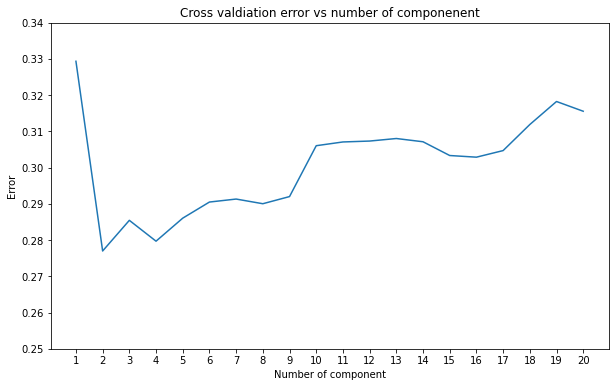

In [66]:
comp = np.arange(1,21)
plt.figure(figsize=(10,6))
plt.title('Cross valdiation error vs number of componenent')
plt.plot(comp, error)
plt.ylabel('Error')
plt.xlabel('Number of component')
plt.yticks(np.arange(0.25,0.35,0.01))
plt.xticks(comp)
plt.show()

In [67]:
# Try training model on single cluster
cluster_X = np.concatenate((X_data[7:14], X_data[35:42], X_data[49:63], X_data[77:84]))
print(cluster_X.shape)
cluster_Y = np.concatenate((Y_data[7:14], Y_data[35:42], Y_data[49:63], Y_data[77:84]))

(35, 720)


In [68]:
error = []
for i in range(20):
    pcr = make_pipeline(PCA(n_components=i+1), LinearRegression())
    linscores = cross_validate(pcr, cluster_X, cluster_Y, scoring='neg_mean_absolute_error', return_estimator=True)
    error.append(-np.average(linscores['test_score']))

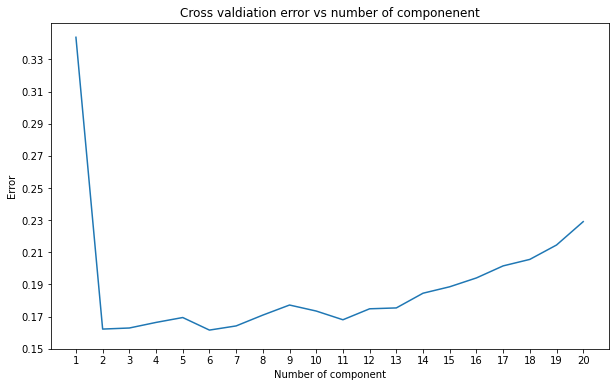

In [69]:
comp = np.arange(1,21)
plt.figure(figsize=(10,6))
plt.title('Cross valdiation error vs number of componenent')
plt.plot(comp, error)
plt.ylabel('Error')
plt.xlabel('Number of component')
plt.xticks(comp)
plt.yticks(np.arange(0.15,0.35,0.02))
plt.show()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(cluster_X, cluster_Y, test_size=0.20, random_state=2)

In [80]:
pcr = make_pipeline(PCA(n_components=2), LinearRegression())
pcr.fit(X_train, y_train)
X_predict = pcr.predict(X_test)

In [81]:
random_list = random.sample(range(0, len(y_test)), 4)

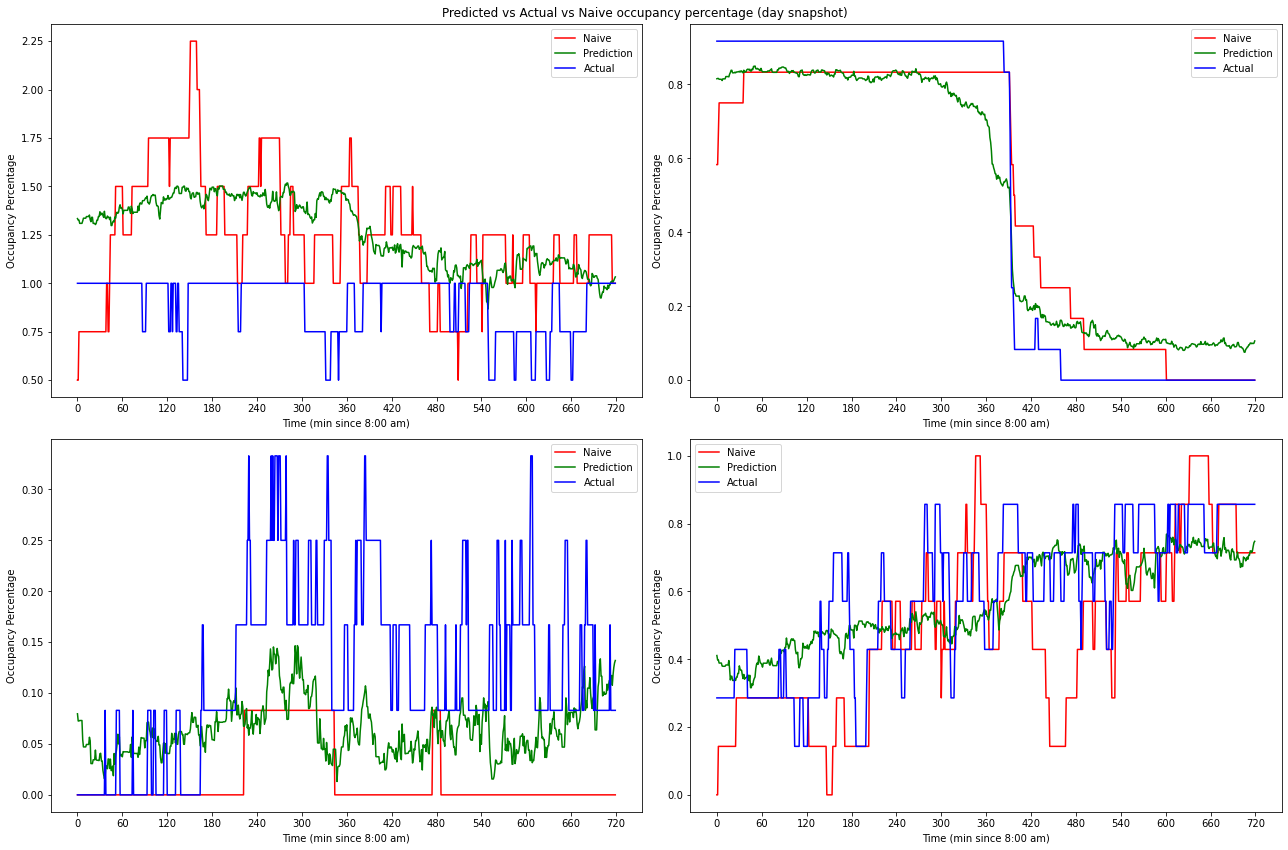

In [82]:
# Display random set of predicted and actual occupancy percentage 
plt.figure(figsize=(18,12))
plt.suptitle('Predicted vs Actual vs Naive occupancy percentage (day snapshot)')

for i in range(4):
    index = random_list[i]
    plt.subplot(2, 2, i+1)
    plt.plot(time, X_test[index], color='r', label='Naive')
    plt.plot(time, X_predict[index], color='g', label='Prediction')
    plt.plot(time, y_test[index], color='b', label='Actual')
    plt.legend()
    plt.xlabel('Time (min since 8:00 am)')
    plt.xticks(np.arange(0,780,60))
    plt.ylabel('Occupancy Percentage')

plt.tight_layout()
plt.show()